In [2]:
from importlib import reload
import galsurvey
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt

reload(galsurvey)

<module 'galsurvey' from 'C:\\Users\\yanlo\\OneDrive - California Institute of Technology\\2019-Bispectrum-Neutrino\\Notebooks\\galsurvey.py'>

In [3]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
#matplotlib.rcParams['font.serif'] = "Times New Roman"
#matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams["figure.dpi"] = 100

In [4]:
omega_m = 0.307494
omega_bh2 = 0.022300
omega_ch2 = 0.118800
omega_l = 1 - omega_m
h = np.sqrt((omega_bh2 + omega_ch2) / omega_m)
omega_b = omega_bh2/h**2
sf = 99.91 #from camb
#sf = 109.5

In [5]:
cosmo_params = {
    'Omega_m': omega_m,
    'Omega_L': omega_l,
    'Omega_b': omega_b,
    'h': h,
    's_f': sf,
    'sigma8_0': 0.9
}

In [6]:
cosmo = galsurvey.cosmology(cosmo_params)
attrs = vars(cosmo)
print(', '.join("%s: %s" % item for item in attrs.items()))

Omega_m: 0.307494, Omega_L: 0.6925060000000001, Omega_b: 0.04859756343019135, h: 0.6773999868566161, s_f: 99.91, sigma8_0: 0.9, astropy_cosmology: FlatLambdaCDM(H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None), D0: 0.7825237557360316


In [7]:
ps_file='planck_camb_56106182_matterpower_z0.dat'
ps_nw_file='planck_camb_56106182_matterpower_smooth_z0.dat'
ps = galsurvey.ps_interpolation(ps_file, ps_nw_file)

In [8]:
survey_geo = {
    'f_sky': 0.5,
    'N_g': 1e100,
    'z_min': 0.1,
    'z_max': 0.2,
    'dz': 0.1
}
survey_params = {
    'Sigma_0': 16.6,
    'reconstruction_rate': 0.5,
    'b_0': 0.95,
    'survey_type': 'spectroscopic'
}

ig_full = ['RSD', 'damping', 'FOG', 'galactic_bias', 'reconstruction']
ig_none = []
ingredients = ig_full


sf_p18 = 97.288
dsf_p18 = 0.799344
pisf = np.pi/sf_p18

priors = {
    'alpha_prior': {
        'mean': sf_p18/sf,
        'stdev': dsf_p18/sf
    },
    'beta_prior': {
        'mean': 1.0,
        'stdev': 1e100 # to be constrained
    }
}

priors_plk = {
    'alpha_prior': {
        'mean': sf_p18/sf,
        'stdev': dsf_p18/sf
    },
    'beta_prior': {
        'mean': 1.0,
        'stdev': 1e100 # to be constrained
    }
}

In [9]:
svy_m = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ['galactic_bias'], priors)
svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ig_full, priors)

In [10]:
region_bs_0={
    'coordinate': 'cartesian',
    'bounds': ((0.01, 0.2),
               (0.01, 0.2),
               (0.01, 0.2),
               (-1, 1),
               (-1, 1))
}
regions_bs = [region_bs_0]

In [11]:
region_ps_0={
    'k_min': 0.01,
    'k_max': 1.0,
    'mu_min': -1.0,
    'mu_max': 1.0
}
regions_ps = [region_ps_0]

In [109]:
zlst = np.linspace(0.2, 4, num=11)
Nglst = [1e6, 1e7, 1e8, 1e100]
# slst = np.zeros((len(Nglst), len(zlst)))
div_k, div_mu = 20, 10
fisherlst_ps = np.zeros((len(Nglst), len(zlst), 2, 2))
fisherlst_bs = np.zeros((len(Nglst), len(zlst), 2, 2))
fisherlst_bs_rsd = np.zeros((len(Nglst), len(zlst), 2, 2))
for j in range(len(zlst)):
    z = zlst[j]
    print('%.2f'%(z))
    survey_geo['z_max']=z
    for i in range(len(Nglst)):
        survey_geo['N_g']=Nglst[i]
        svy_m = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ['galactic_bias'], priors)
        svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ig_full, priors)
        #svy.cosmo = cosmo
        #svy.ps = ps
        #svy.get_ready()
        fisherlst_ps[i,j] = svy.fisher_matrix_ps(regions_ps, div_k=20, div_mu=10, addprior=False)
        fisherlst_bs[i,j] = svy_m.fisher_matrix_bs(regions_bs, divs=(10, 10, 10, 10, 10), addprior=False, unique=True)
        fisherlst_bs_rsd[i,j] = svy.fisher_matrix_bs(regions_bs, divs=(10, 10, 10, 10, 10), addprior=False, unique=True)

0.20
0.58
0.96
1.34
1.72
2.10
2.48
2.86
3.24
3.62
4.00


In [110]:
prior = np.array([[1/(dsf_p18/sf)**2, 0],
                 [0, 1e-100]])

def get_constraint(fisherlst, addprior=False, single=False):
    alst = np.zeros(len(fisherlst))
    blst = np.zeros(len(fisherlst))
    alst_s = np.zeros(len(fisherlst))
    blst_s = np.zeros(len(fisherlst))
    
    if addprior:
        pr = prior
    else:
        pr = np.array([[1e-100,0],
                      [0,1e-100]])
        
    for j in range(len(fisherlst)):
        if not single:
            alst[j] = np.sqrt(np.linalg.inv(fisherlst[j]+pr)[0,0])
            blst[j] = np.sqrt(np.linalg.inv(fisherlst[j]+pr)[1,1])
        if single:
            alst[j] = 1/np.sqrt(fisherlst[j][0,0])
            blst[j] = 1/np.sqrt(fisherlst[j][1,1])
    return alst, blst
    

In [116]:
Ng_labels = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
prior_labels = [r'w/ $\alpha$ prior', r'w/o $\alpha$ prior', 'Single']
sigma_labels = ['alst', 'blst']
cons_labels = ['PS', 'BiS-no-RSD', 'BiS']
fisherlsts = [fisherlst_ps, fisherlst_bs, fisherlst_bs_rsd]
conslst = {}

for kk in range(len(cons_labels)):
    cons_label = cons_labels[kk]
    cons = conslst[cons_label] = {}
    fisherlst = fisherlsts[kk]
    for i in range(len(Nglst)):
        ng_label = Ng_labels[i]
        cons[ng_label] = {}
        for j in range(len(prior_labels)):
            prior_label = prior_labels[j]
            cons[ng_label][prior_label] = {}
            if prior_label == '+ prior':
                addprior = True
            else:
                addprior = False
            if prior_label == 'Single':
                single = True
            else:
                single = False
            
            sigmas = get_constraint(fisherlst[i], addprior=addprior, single=single)
            for k in range(len(sigma_labels)):
                sigma_label = sigma_labels[k]
                cons[ng_label][prior_label][sigma_label] = sigmas[k]

In [117]:
Ng_labels_full = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
prior_labels_full = [r'w/ $\alpha$ prior', r'w/o $\alpha$ prior', 'Single']
sigma_labels_full = ['alst', 'blst',]
cons_labels_full = ['PS', 'BiS-no-RSD', 'BiS']


Ng_labels = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
prior_labels = ['+ prior', '- prior', 'Single']
sigma_labels = ['alst', 'blst', ]
cons_labels = ['PS', 'BS']
suffix = '_all.pdf'


Ng_labels = [r'\rm CVL', r'$N_g=10^7$']
prior_labels = ['+ prior', '- prior']
sigma_labels = ['alst', 'blst']
cons_labels = ['PS', 'BS']
suffix = '_ps_bs_cvl_Ng.pdf'



# Ng_labels = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
# prior_labels = ['+ prior', '- prior']
# sigma_labels = ['alst', 'blst']
# cons_labels = ['PS']
# suffix = '_ps.pdf'


# Ng_labels = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
# prior_labels = ['+ prior', '- prior']
# sigma_labels = ['alst', 'blst']
# cons_labels = ['BS']
# suffix = '_bs.pdf'

# Ng_labels = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
# prior_labels = ['+ prior', '- prior']
# sigma_labels = ['alst', 'blst']
# cons_labels = ['PS']
# suffix = '_ps_prior.pdf'


Ng_labels = [ r'$N_g=10^7$',  r'\rm CVL']
prior_labels = [r'w/ $\alpha$ prior', r'w/o $\alpha$ prior']
sigma_labels = ['alst', 'blst']
cons_labels = ['BiS-no-RSD', 'BiS']
suffix = '_bs_bsrsd.pdf'



def b2n(x):
    return 4.4/1.45 - 4.4* (-x + 1)/(2.45 - (-x + 1))
def n2b(y):
    t = 4.4/1.45 -y
    return 1 - 2.45*t/(t+4.4)


NUM_COLORS = len(cons_labels_full)*len(Ng_labels_full)
cm = plt.get_cmap('tab20')
colors=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


def get_color(cons_label, ng_label):
    i = cons_labels_full.index(cons_label)
    j = Ng_labels_full.index(ng_label)
    c = colors[i*len(Ng_labels_full)+j]
    #print(i,j,c)
    return c

def get_linestyle(prior_label):
    if prior_label == prior_labels_full[0]:
        return '-'
    if prior_label == prior_labels_full[1]:
        return '-.'
    if prior_label == prior_labels_full[2]:
        return ':'

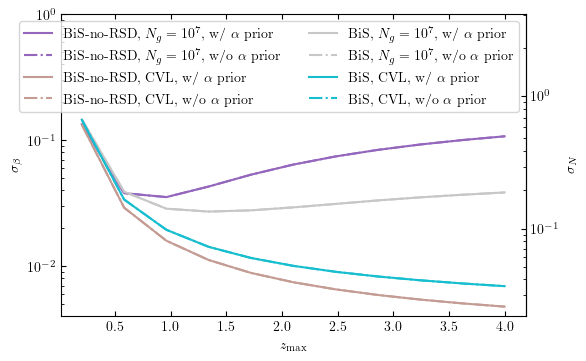

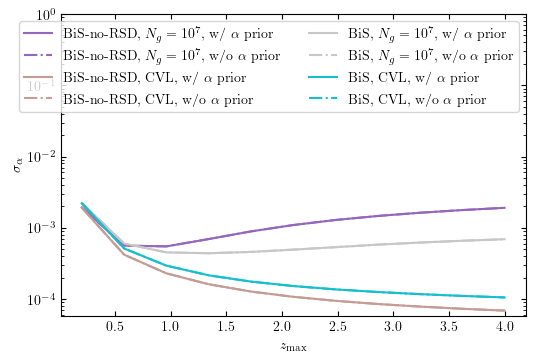

In [118]:
for toshow in ['beta', 'alpha']:
    ymax = 0.
    if toshow == 'alpha':
        slst = 'alst'
        fixed = r'$\beta$ fixed'
        ylabel = r'$\sigma_\alpha$'
        fname = 'sigma_alpha'+suffix

    elif toshow == 'beta':
        slst = 'blst'
        fixed = r'$\alpha$ fixed'
        ylabel = r'$\sigma_\beta$'
        fname = 'sigma_beta'+suffix

    if toshow == 'beta':
        matplotlib.rcParams['ytick.right'] = False


    #fig, ax = plt.subplots(figsize=(15, 10))
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    #ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    if toshow == 'beta':
        ax_r = ax.secondary_yaxis("right", functions=(b2n, n2b))

    for cons_label in cons_labels:
        cons = conslst[cons_label]
        for ng_label in Ng_labels:
            c = get_color(cons_label, ng_label)
            for prior_label in prior_labels:
                if slst in sigma_labels:
                    ls = get_linestyle(prior_label)
                    ylst = cons[ng_label][prior_label][slst]
                    if np.max(ylst) > ymax:
                        ymax = np.max(ylst)
                    plt.semilogy(zlst, ylst, label = cons_label+', '+ng_label+', '+prior_label, ls=ls, c=c)
    ax.set_ylim((None, 1))
    ax.legend(loc='upper right', ncol=2)
    ax.set_xlabel(r'$z_{\rm max}$')
    ax.set_ylabel(ylabel)
    if toshow == 'beta':
        ax_r.set_ylabel(r'$\sigma_N$')
    #ax.set_ylim(0,1.2)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    if toshow == 'beta':
        matplotlib.rcParams['ytick.right'] = True
    plt.close()